## Goal: To show how each culture diffuses by their ingredients. 

#### To know more about 'json':https://www.w3schools.com/python/python_json.asp
#### About TfidfTransformer:http://lijiancheng0614.github.io/scikit-learn/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html

### SECTION 1: From JSON to a countsMatrix 
#### CountsMatrix is a matrix where the [i,j] cell is the number of times ingredient j appears in cuisine i (total number of appearances over all recipes for that cuisine). This is a preliminary step required for running tf-idf. 

In [1]:
import numpy as np
import json
from sklearn.feature_extraction.text import TfidfTransformer

In [2]:
with open('train.json') as data_file:    
    data = json.load(data_file) # create a list of data

In [3]:
data[0]

{'id': 10259,
 'cuisine': 'greek',
 'ingredients': ['romaine lettuce',
  'black olives',
  'grape tomatoes',
  'garlic',
  'pepper',
  'purple onion',
  'seasoning',
  'garbanzo beans',
  'feta cheese crumbles']}

#### In this function, we create a dictionary of cuisine ingredients(ingredient can be repeated), and we put all cuisines into list cuisines and ingredients into list gredients(cannot be repeated).

In [4]:
def create_dict_cuisine_ingred(json):
    dictCuisineIngred = {}
    cuisines = []
    ingredients = []
    for i in range(len(json)):
        cuisine = json[i]['cuisine']
        if cuisine == 'southern_us':   #just to make the name more readable
            cuisine = 'southUS'
        ingredientsPerCuisine = json[i]['ingredients']
        if cuisine not in dictCuisineIngred.keys():
            cuisines.append(cuisine)   # add this new cuisine into cuisine list
            dictCuisineIngred[cuisine] = ingredientsPerCuisine   #create a new dic pair
            
        else: 
            currentList = dictCuisineIngred[cuisine]   #get ingredient value out
            currentList.extend(ingredientsPerCuisine)   # append ingredients in
            dictCuisineIngred[cuisine] = currentList    #put ingredients value back
                 
        ingredients.extend(ingredientsPerCuisine)
         
    ingredients = list(set(ingredients)) # unique list of ALL ingredients
    numUniqueIngredients = len(ingredients)
    numCuisines = len(cuisines)
    return dictCuisineIngred, numCuisines, numUniqueIngredients, cuisines, ingredients

In [5]:
def create_term_count_matrix(dictionary, numCuisines, numIngred, cuisines, ingredients):
    termCountMatrix = np.zeros((numCuisines,numIngred))
    i = 0
    
    for cuisine in cuisines:
        ingredientsPerCuisine = dictCuisineIngred[cuisine]

        for ingredient in ingredientsPerCuisine:
            j = ingredients.index(ingredient) #return the index of the ingredient as per its position in ingredients list
            termCountMatrix[i,j] += 1   #1 means the ingredient appears one time, cuisine is row and column is ingredient

        i += 1   #next cuisine

    return termCountMatrix

In [6]:
dictCuisineIngred, numCuisines, numIngred, cuisines, ingredients = create_dict_cuisine_ingred(data)
countsMatrix = create_term_count_matrix(dictCuisineIngred, numCuisines, numIngred, cuisines, ingredients)
print(countsMatrix)    #count matrix created

[[ 0. 12.  2. ...  0.  0.  0.]
 [ 1. 27.  4. ...  0.  1.  0.]
 [ 0.  3.  0. ...  0.  0.  0.]
 ...
 [ 0.  2.  3. ...  0.  0.  2.]
 [ 0. 16.  0. ...  0.  0.  0.]
 [ 0.  1.  0. ...  0.  2.  0.]]


### As we can see from the count matrix above, the matrix is comprised of mostly zero values. This is called sparse matrix. To deal with it, first we calculate the tf-idf weight of each cell in matrix and get the tf-idf matrix. Then we use pca to compress the data and obtain two vectors for visualization purposes.

#### About Sparse Matrix:https://machinelearningmastery.com/sparse-matrices-for-machine-learning/
#### About tf-idf:https://en.wikipedia.org/wiki/Tf%E2%80%93idf#Example_of_tf%E2%80%93idf
#### About PCA:https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c

### SECTION 2: tf-idf + pca 
#### This section creates 'reduced_data' which is the countsMatrix above after pca where we took only the first two principal components

In [7]:
import pandas as pd
from scipy import sparse
from sklearn.decomposition import PCA
get_ipython().magic(u'matplotlib inline')

In [8]:
def tf_idf_from_count_matrix(countsMatrix):
    
    countsMatrix = sparse.csr_matrix(countsMatrix)  #convert the sparse matrix to csr sparse representation
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(countsMatrix) # computes tf-idf
    tfidf.toarray() 
    return tfidf.toarray()

In [9]:
tfIdf_Matrix = tf_idf_from_count_matrix(countsMatrix)  # creating the tf-idf matrix
print(tfIdf_Matrix)

[[0.         0.00878208 0.00205715 ... 0.         0.         0.        ]
 [0.00079317 0.00639012 0.00133053 ... 0.         0.00062913 0.        ]
 [0.         0.00322073 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.00159603 0.00336476 ... 0.         0.         0.00313634]
 [0.         0.01389715 0.         ... 0.         0.         0.        ]
 [0.         0.00181976 0.         ... 0.         0.00967466 0.        ]]


In [10]:
pca = PCA(n_components=2)  # running PCA to reduce to 2 dimensions
reduced_data = pca.fit_transform(tfIdf_Matrix)  #Fit the model and apply the dimensionality reduction
print(reduced_data)

[[-0.25779112 -0.32174681]
 [-0.30543777  0.35523475]
 [ 0.20269482  0.03599675]
 [-0.00185797 -0.21124362]
 [-0.02506863 -0.01278191]
 [-0.25957047 -0.28795852]
 [-0.29765539 -0.19242974]
 [-0.07487366 -0.32684739]
 [ 0.56008247  0.16106029]
 [-0.33068786  0.4254587 ]
 [ 0.57496206 -0.15100075]
 [ 0.56358434 -0.05306437]
 [-0.18777292 -0.06949352]
 [-0.09842317 -0.17692865]
 [-0.3306676   0.16312994]
 [ 0.46796383  0.22765828]
 [-0.3190478   0.39171183]
 [ 0.5604849   0.14183813]
 [-0.17645762 -0.40211836]
 [-0.26446044  0.30352499]]


In [11]:
pca2dataFrame = pd.DataFrame(reduced_data)   # converting to pandas dataframe for convenience
pca2dataFrame.columns = ['PC1', 'PC2']
print(pca2dataFrame)

         PC1       PC2
0  -0.257791 -0.321747
1  -0.305438  0.355235
2   0.202695  0.035997
3  -0.001858 -0.211244
4  -0.025069 -0.012782
5  -0.259570 -0.287959
6  -0.297655 -0.192430
7  -0.074874 -0.326847
8   0.560082  0.161060
9  -0.330688  0.425459
10  0.574962 -0.151001
11  0.563584 -0.053064
12 -0.187773 -0.069494
13 -0.098423 -0.176929
14 -0.330668  0.163130
15  0.467964  0.227658
16 -0.319048  0.391712
17  0.560485  0.141838
18 -0.176458 -0.402118
19 -0.264460  0.303525


### Here we get the pca dataframe, which shows the position of each cuisine in our final plot. PC1 is the x-axis and PC2 is the y-axis.

#### About k-means: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

### SECTION 3: KMeans clustering
#### Here we use KMeans to cluster the reduced_data. Clustering into 3 groups seems to be right.

In [18]:
from sklearn.cluster import KMeans

def kmeans_cultures(numOfClusters):
    
    kmeans = KMeans(init='k-means++', n_clusters=numOfClusters, n_init=10)
    kmeans.fit(reduced_data)     # Compute k-means clustering
    return kmeans.predict(reduced_data)   # predict cluster index for each sample

labels = kmeans_cultures(3) # If 4 clusters, jamaican and filipino will be grouped together. Since they're far away from each other,cluster them into 3
print(labels)

[2 0 1 2 2 2 2 2 1 0 1 1 2 2 0 1 0 1 2 0]


#### About Jaccard similarity: https://dataconomy.com/2015/04/implementing-the-five-most-popular-similarity-measures-in-python/

### SECTION 4: SIZE OF BUBBLES
####  We intersect all ingredients of cuisine i with the union of  ingredients in all other cuisines in its cluster and divide by the union of all ingredients in the cluster. This method is called Jaccard similarity.

In [19]:
# To get sizes of bubbles

i = 0 
j = 0 

effect_on_cluster = [0 for cuisine in cuisines]  # [0,0...0]

for cuisineA in cuisines:  

    A_intersection = 0
    numInClusterBesidesA = 0
    setA = set(dictCuisineIngred[cuisineA])   # set of cuisine A
    setB_forA = []  # set of all cuisines in the same cluster except cuisine A
    j = 0
    
    for cuisineB in cuisines:
        if cuisineB != cuisineA:   # if it is A itself - will be exactly 1
            if labels[j] == labels[i]:   #determines if then they are both in the same cluster
                setB_forA.extend(set(dictCuisineIngred[cuisineB]))
                numInClusterBesidesA += 1
        j += 1
    # Jaccard similarity:
    A_intersection = len(set(setA & set(setB_forA))) / float(len(set(setA.union(setB_forA)))) #how similar cuisine A is with other cuisines in the same cluster
    effect_on_cluster[i] = A_intersection
       
    i += 1
print(effect_on_cluster)

[0.21818181818181817, 0.4278336504484914, 0.2506443298969072, 0.2656126482213439, 0.16126482213438736, 0.233201581027668, 0.42727272727272725, 0.4007905138339921, 0.4333118556701031, 0.2737156836096765, 0.3704896907216495, 0.3173324742268041, 0.27213438735177864, 0.15276679841897234, 0.41967926066865996, 0.3540592783505155, 0.24707801032889373, 0.25128865979381443, 0.1816205533596838, 0.2082087523783637]


### SECTION 5: Final plot
#### The size of the bubble is determined by the within-cluster similarity which is obtained by the Jaccard similarity of each cuisine with other members in it its cluster (computed above). We use scatter plot to show.

C:\Users\B0175\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


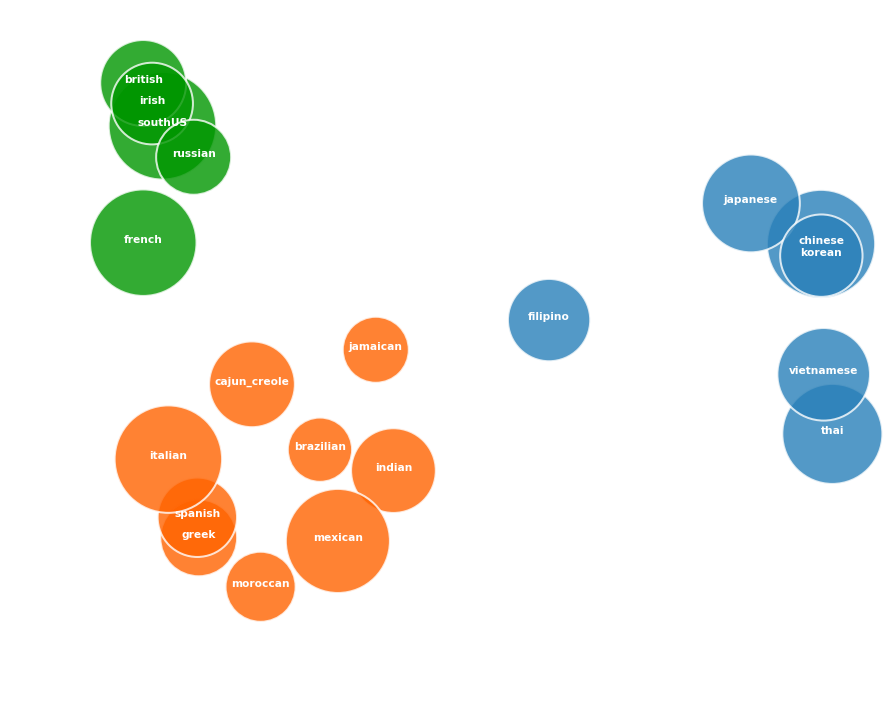

In [20]:
from pylab import *
from scipy import *
import matplotlib.pyplot as plt

rdata = reduced_data
i=0
figureRatios = (15,20)
x = []
y = []
color = []
area = []

#creating a color palette:
colorPalette = ['#009600','#2980b9', '#ff6300','#2c3e50', '#660033'] 
# green,blue, orange, grey, purple

plt.figure(1, figsize=figureRatios)

for data in rdata:
    x.append(data[0])  
    y.append(data[1])  
    color.append(colorPalette[labels[i]]) 
    area.append(effect_on_cluster[i]*27000) # magnifying the bubble's sizes (all by the same unit)
    # plotting the name of the cuisine: 
    # Add the text cuisine[i] to the axes at location data[0], data[1] in data coordinates
    text(data[0], data[1], cuisines[i], size=10.6,horizontalalignment='center', fontweight = 'bold', color='w')
    i += 1

plt.scatter(x, y, c=color, s=area, linewidths=2, edgecolor='w', alpha=0.80) 

plt.axis([-0.45,0.65,-0.55,0.55])   #(xmin, xmax, ymin, ymax)
plt.axes().set_aspect(0.8, 'box')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('off') # removing the PC axes

plt.show()

### From the plot above, we can find many interesting things. For example, if we cluster them into 4 groups, jamaican will be clustered with filipino. But as we know, from their position on the earth, they shouldn't be together. Filipino is from Asia. Nevertheless, it is far away from other Asian culture. This may clearly show its uniqueness in Asia. What's more, Korean is inside Chinese. It may mean that most korean cuisines is originally from Chinese since Chinese circle is much bigger. Another one is that in orange cluster, italian, spanish and greek are clustered together. At the same time, they are all European countries. So they should be together and intersect. 